In [1]:
import numpy as np
from datetime import datetime

# Three model choices:
# A: Baseline ["model_choice": "baseline", "include_frame": False, "object_representations": False]
# B: Object-centric ["model_choice": "object_centric", "include_frame": False, "object_representations": False]
# C: Object-centric with object representations ["model_choice": "object_centric", "include_frame": False, "object_representations": True]

args = {
    "model_choice": "baseline",
    "include_frame": False,
    "object_representations": False,
    "nt": 2,
    "sequences_per_epoch_train": 100,
    "sequences_per_epoch_val": 10,
    "batch_size": 1,
    "nb_epoch": 50,
    "second_stage": True,
    "output_channels": [3, 48, 96, 192],
    "downscale_factor": 4,
    "resize_images": False,
    "decompose_images": True,
    "training_split": 1.0,
    "seed": np.random.randint(0, 1000),
    "results_subdir": f"{str(datetime.now())}",
    "restart_training": False,
    "reserialize_dataset": True,
    "output_mode": "Error",
    "learning_rates": [1e-3, 1e-3, 1e-3, 5e-4, 1e-4],
    "pretrain_classifier": False,
    "load_outside_pretrained_classifier_weights": True,
    "debug_model": False,
    "system": "laptop",
    "dataset": "SSM",
    "data_subset": "multiShape",
    "dataset_size": 10000,
    "num_iterations": 8,
    "restart_iteration": 2,
    "SSM_im_shape": [64, 64],
    "pretrain_OR_VAE": False,
    "top_down_attention": False,
}

args["results_subdir"] = f"eval_results/{args['dataset']}/{args['data_subset']}"

In [2]:
import os
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
# or '2' to filter out INFO messages too
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
import tensorflow as tf
import numpy as np
from data_utils import SequenceDataLoader
import matplotlib.pyplot as plt
from config import update_settings, get_settings

keras.utils.set_random_seed(args['seed']) # need keras 3 i think

update_settings(args["system"], args["dataset"], args["data_subset"], args["results_subdir"])
DATA_DIR, WEIGHTS_DIR, RESULTS_SAVE_DIR, LOG_DIR = get_settings()["dirs"]
data_dirs = [DATA_DIR, WEIGHTS_DIR, RESULTS_SAVE_DIR, LOG_DIR]

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(RESULTS_SAVE_DIR, exist_ok=True)
# print all args to file
with open(os.path.join(RESULTS_SAVE_DIR, "job_args.txt"), "w+") as f:
    for key, value in args.items():
        f.write(f"{key}: {value}\n")

save_model = True  # if weights will be saved
plot_intermediate = True  # if the intermediate model predictions will be plotted
tensorboard = False  # if the Tensorboard callback will be used

# Training parameters
if args["model_choice"] == "baseline":
    if args["decompose_images"] or args["object_representations"]: 
        print("Baseline PredNet does not use decomposed images or object representations, disabling both.")
        args["decompose_images"] = False
        args["object_representations"] = False
if args["object_representations"]:
    # args["batch_size"] = 1
    args["include_frame"] = False
    print("Object representations are being used. Not predicting last frame either.")
if args["decompose_images"]:
    args["output_channels"][0] = 12 # We constrain to the SSM dataset and four object images
    if args["include_frame"]:
        args["output_channels"][0] += 3 # Add the original frame channels
if args["pretrain_classifier"]:
    args["output_channels"] = args["output_channels"][:1] # Just need the bottom layer
    # args["nt"] = 1
    # args["batch_size"] = args["batch_size"] * 16
    # args["sequences_per_epoch_train"] = args["sequences_per_epoch_train"] // 16
    plot_intermediate = False
nt = args["nt"]  # number of time steps
nb_epoch = args["nb_epoch"]  # 150
batch_size = args["batch_size"]  # 4
# the following two will override the defaults of (dataset size / batch size)
sequences_per_epoch_train = args["sequences_per_epoch_train"]  # 500
sequences_per_epoch_val = args["sequences_per_epoch_val"]  # 500
assert sequences_per_epoch_train is None or type(sequences_per_epoch_train) == int
assert sequences_per_epoch_val is None or type(sequences_per_epoch_val) == int
output_channels = args["output_channels"]

"""Create datasets"""
print("Creating datasets...")
# Define image shape
assert args["dataset"] == "SSM", "this branch is focused on the SSM dataset"
original_im_shape = (args["SSM_im_shape"][0], args["SSM_im_shape"][1], args["output_channels"][0])
downscale_factor = args["downscale_factor"]
im_shape = (original_im_shape[0] // downscale_factor, original_im_shape[1] // downscale_factor, args["output_channels"][0]) if args["resize_images"] else original_im_shape

# Always 2nd stage training for object-centric model because the random backgrounds are applied at decomposition time
# stage = ("2nd_stage" if args["second_stage"] else "1st_stage") if args["model_choice"] == "baseline" else "2nd_stage"
# train_dataset, train_size = SequenceDataLoader(args, DATA_DIR + f"multi_gen_shape_strafing/frames/multi_gen_shape_{stage}_train", nt, batch_size, im_shape[0], im_shape[1], im_shape[2], True, args["include_frame"]).create_tf_dataset()
# val_dataset, val_size = SequenceDataLoader(args, DATA_DIR + f"multi_gen_shape_strafing/frames/multi_gen_shape_{stage}_val", nt, batch_size, im_shape[0], im_shape[1], im_shape[2], True, args["include_frame"]).create_tf_dataset()
# test_dataset, test_size = SequenceDataLoader(args, DATA_DIR + "multi_gen_shape_strafing/frames/multi_gen_shape_2nd_stage_image_pairs_test", nt, batch_size, im_shape[0], im_shape[1], im_shape[2]).create_tf_dataset()

print(f"Working on dataset: {args['dataset']} - {args['data_subset']} {'1st Stage' if not args['second_stage'] else '2nd Stage'}")
# print(f"Train size: {train_size}")
# print(f"Validation size: {val_size}")
# print(f"Test size: {test_size}")
# print("All datasets created successfully")


"""Model Setup"""
# PICK MODEL
if args["model_choice"] == "baseline":
    from PN_models.PN_Baseline import PredNet
    print("*** Using Baseline PredNet ***")
elif args["model_choice"] == "object_centric":
    assert args["decompose_images"], "Object-Centric PredNet requires images to be decomposed"
    from PN_models.PN_ObjectCentric import PredNet
    if args["object_representations"]:
        print("*** Using the Object-Centric PredNet; Decomposing & classifying inputs, and maintaining & applying object representations ***")
        if args["pretrain_classifier"]:
            from PN_models.PN_ObjectCentric import BatchDataLoader_pretrainC
    else:
        print("*** Using the Object-Centric PredNet; Decomposing inputs ***")
else:
    raise ValueError("Invalid model choice")

# Create PredNet with animation specific input shapes
inputs = keras.Input(shape=(nt, im_shape[0], im_shape[1], im_shape[2]), batch_size=batch_size)
PN = PredNet(args, im_height=im_shape[0], im_width=im_shape[1])
outputs = PN(inputs)
PN = keras.Model(inputs=inputs, outputs=outputs)

# Finalize model
resos = PN.layers[-1].resolutions
PN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
print("PredNet compiled...")
PN.build(input_shape=(batch_size, nt) + im_shape)
print(PN.summary())
num_layers = len(output_channels)  # number of layers in the architecture
print(f"{num_layers} PredNet layers with resolutions:")
for i in reversed(range(num_layers)):
    print(f"Layer {i+1}:  {resos[i][0]} x {resos[i][1]} x {output_channels[i]}")


"""Weights Setup"""
# Define where weights will be loaded/saved
if args["model_choice"] == "baseline":
    weights_file_name = "baseline_weights.hdf5"
elif args["model_choice"] == "object_centric" and not args["object_representations"] and not args["include_frame"]:
    weights_file_name = "objectCentric_weights.hdf5"
elif args["model_choice"] == "object_centric" and not args["object_representations"] and args["include_frame"]:
    weights_file_name = "objectCentric_weights_includeFrame.hdf5"
elif args["model_choice"] == "object_centric" and args["object_representations"] and not args["include_frame"]:
    weights_file_name = "objectCentric_withObjectRepresentations_weights.hdf5"
    classifier_weights_file_name = "OCPN_wOR_Classifier_weights.npz"
weights_file = os.path.join(WEIGHTS_DIR, weights_file_name)
# Define where weights will be saved with results
results_weights_file = os.path.join(RESULTS_SAVE_DIR, "tensorflow_weights/" + weights_file_name)
# Remove weights file if restarting training. Previous weights can still be found with the results
if args["restart_training"]:
    # if os.path.exists(weights_file):
        # os.remove(weights_file)
    print("Restarting training from scratch")
# load previously saved weights
else:
    print("Loading weights...")
    if os.path.exists(weights_file):
        try: 
            PN.load_weights(weights_file)
            print("PN model weights loaded successfully - Ready for testing")
        except: 
            # os.remove(weights_file) # model architecture has changed, so weights cannot be loaded
            print("PN model weights don't fit - restarting training from scratch")
    else: print("No PN model weights found - starting training from scratch") if not args["restart_training"] else None
if args["load_outside_pretrained_classifier_weights"] and args["object_representations"]:
    if os.path.exists(os.path.join(WEIGHTS_DIR, classifier_weights_file_name)):
        try:
            # custom_objects = {'dummy_model': dummy_model}
            # trained_classifier_weights = keras.models.load_model(os.path.join(WEIGHTS_DIR, classifier_weights_file_name), custom_objects=custom_objects).layers[1].layers[0].classifier.get_weights()
            trained_classifier_weights = np.load(os.path.join(WEIGHTS_DIR, classifier_weights_file_name), allow_pickle=True)
            trained_classifier_weights = [trained_classifier_weights[key] for key in trained_classifier_weights.keys()]
            un_trained_classifier = PN.layers[1].layers[0].layers[2].classifier
            un_trained_classifier.set_weights(trained_classifier_weights)
            print("Pre-trained Classifier weights loaded successfully")
        except:
            print("Pre-trained Classifier weights don't fit... better fix it")
    else:
        print("No classifier weights found - starting training from scratch")

Baseline PredNet does not use decomposed images or object representations, disabling both.
Creating datasets...
Working on dataset: SSM - multiShape 2nd Stage
*** Using Baseline PredNet ***
PredNet compiled...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 2, 64, 64, 3)]       0         
                                                                 
 pred_net (PredNet)          (1, 1)                    6915948   
                                                                 
Total params: 6915948 (26.38 MB)
Trainable params: 6915948 (26.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
4 PredNet layers with resolutions:
Layer 4:  8 x 8 x 192
Layer 3:  16 x 16 x 96
Layer 2:  32 x 32 x 48
Layer 1:  64 x 64 x 3
Loading weights...
PN model weights loaded successfully - Ready for testing


PN layer set up for testing...
Completed iteration 10/5000
Completed iteration 20/5000
Completed iteration 30/5000
Completed iteration 40/5000
Completed iteration 50/5000
Completed iteration 60/5000
Completed iteration 70/5000
Completed iteration 80/5000
Completed iteration 90/5000
Completed iteration 100/5000
Total steps: 100
Average MSE Predicted-Frame: 0.01225
Average MSE Copy-Prev-Frame: 0.03148


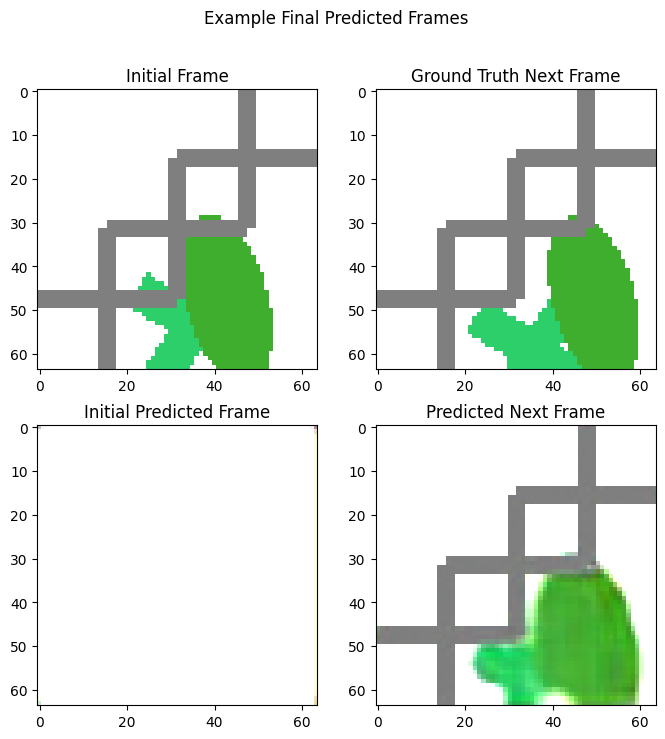

In [3]:
# CALC MSE for SINGLE and MULTI SHAPE TASKS
from PIL import Image
mse_predicted_frame_total = 0
mse_copy_prev_frame_total = 0

from PIL import Image
import numpy as np
import os

from PN_models.PN_ObjectCentric import SceneDecomposer

scenedecomposer = SceneDecomposer()

def process_image(image_path):
    # Load and process the image (example processing)
    img = Image.open(image_path)
    img_array = np.array(img, dtype=np.float32) / 255.0
    if args["decompose_images"]:
        img_array = scenedecomposer.process_single_image(img_array) / 255.0
    return img_array

def iterate_images_in_steps_of_two(folder_path):
    image_filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    
    for i in range(0, len(image_filenames) - 1, 2):
        image_path_1 = os.path.join(folder_path, image_filenames[i])
        image_path_2 = os.path.join(folder_path, image_filenames[i + 1])
        
        image_1 = process_image(image_path_1)
        image_2 = process_image(image_path_2)

        image_1 = np.reshape(image_1, (1, 1, 64, 64, -1))
        image_2 = np.reshape(image_2, (1, 1, 64, 64, -1))

        image_pair = np.concatenate([image_1, image_2], axis=1)
        
        # print(f"Processed image pair: {image_path_1}, {image_path_2}")
        
        # Return the pair of images or perform additional processing
        yield (i+2), image_pair

def reconstruct_frame(decomposed_frame):
    pred_masks = decomposed_frame
    h, w, n_c = pred_masks.shape
    n = n_c // 3  # Number of masks
    
    # Form reconstructions
    pred_masks_reshaped = tf.reshape(pred_masks, (h, w, n, 3))
    reconstructed_image = tf.minimum(1.0, tf.reduce_max(pred_masks_reshaped, axis=2))
    reconstructed_image = tf.cast(reconstructed_image, tf.float32)

    return reconstructed_image

# Set up PN model for testing
PN_layer = PN.layers[-1]
PN_layer.output_mode = "Prediction"
PN_layer.continuous_eval = True
print("PN layer set up for testing...")

# Example usage
folder_path = DATA_DIR + "multi_gen_shape_strafing/frames/multi_gen_shape_2nd_stage_image_pairs_train"
test_size = len([f for f in os.listdir(folder_path) if f.endswith('.png')]) // 2
for i, image_pair in iterate_images_in_steps_of_two(folder_path):
    # manually initialize PN layer states
    PN_layer.init_layer_states()

    # Predict the next frame given the initial frame
    predicted_frames = PN_layer(image_pair)[0]

    if args["model_choice"] == "baseline":
        initial_frame = image_pair[0, 0]
        ground_truth_next_frame = image_pair[0, 1]
        initial_predicted_frame = predicted_frames[0]
        predicted_next_frame = predicted_frames[1]
    elif args["model_choice"] == "object_centric":
        initial_frame = reconstruct_frame(image_pair[0, 0])
        ground_truth_next_frame = reconstruct_frame(image_pair[0, 1])
        initial_predicted_frame = reconstruct_frame(predicted_frames[0])
        predicted_next_frame = reconstruct_frame(predicted_frames[1])
    
    # Calculate the error between the predicted and ground truth next frame
    error_predicted_frame = ground_truth_next_frame - predicted_next_frame
    error_copy_prev_frame = ground_truth_next_frame - initial_frame
    mse_predicted_frame = np.mean(error_predicted_frame**2)
    mse_copy_prev_frame = np.mean(error_copy_prev_frame**2)
    mse_predicted_frame_total += mse_predicted_frame
    mse_copy_prev_frame_total += mse_copy_prev_frame
    print(f"Completed iteration {i//2}/{test_size}") if (i//2) % 10 == 0 else None

    if (i//2) % 100 == 0: break

    PN_layer.clear_layer_states()

# Wrap up results
total_steps = i//2
print(f"Total steps: {total_steps}")
print(f"Average MSE Predicted-Frame: {mse_predicted_frame_total/total_steps:.5f}")
print(f"Average MSE Copy-Prev-Frame: {mse_copy_prev_frame_total/total_steps:.5f}")

# As an example, plot the last image pair and the predicted next frames in a 2x2 grid with a defined fig size
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle("Example Final Predicted Frames")
axs[0, 0].imshow(initial_frame)
axs[0, 0].set_title("Initial Frame")
axs[0, 1].imshow(ground_truth_next_frame)
axs[0, 1].set_title("Ground Truth Next Frame")
axs[1, 0].imshow(initial_predicted_frame)
axs[1, 0].set_title("Initial Predicted Frame")
axs[1, 1].imshow(predicted_next_frame)
axs[1, 1].set_title("Predicted Next Frame")
plt.show()

In [4]:
# # CALC MSE for CLASS-STATE CONDITIONAL TASK
# # need to threshold the ground truth and predicted images to set anything not white to black

# mse_total = 0
# mse_prev_total = 0
# steps = 0
# for i in range(0, td_len, 2):
#     # note that the dataset is composed of prediction-pairs of images, thus we traverse it in steps of 2
#     if np.min(test_data[i]) == 1.0:
#         print(f"Skipping iteration {i} as it is a white frame...")
#         continue
#     steps += 1
#     # manually initialize PN layer states
#     PN.layers[-1].init_layer_states()
#     for j in range(2):
#         # ground_truth_image = next(dataset_iter)[0]
#         print(f"Iteration {i+j}/{td_len}") if (i+j) % 100 == 0 else None
#         ground_truth_image = np.reshape(test_data[i+j], (1, 1, *test_data.shape[1:]))
#         if j == 0:
#             prev_image = ground_truth_image
#         predicted_image = PN.layers[-1](ground_truth_image)
#         if j == 1:
#             # binarize the images to avoid wrong-color error accumulation because color is unpredictable
#             gt_mask = np.any(ground_truth_image != 1.0, axis=-1)
#             pred_mask = np.any(predicted_image != 1.0, axis=-1)
#             prev_mask = np.any(prev_image != 1.0, axis=-1)
#             gt = np.where(gt_mask, 0.0, 1.0)
#             pred = np.where(pred_mask, 0.0, 1.0)
#             prev = np.where(prev_mask, 0.0, 1.0)

#             error_image = gt - pred
#             error_prev_image = gt - prev
#             mse = np.mean(error_image**2)
#             mse_prev = np.mean(error_prev_image**2)
#             mse_total += mse
#             mse_prev_total += mse_prev

# print(f"Total steps taken: {steps}")
# print(f"Average MSE: {mse_total/steps:.5f}")
# print(f"Average MSE Prev: {mse_prev_total/steps:.5f}")

In [5]:
# # SETUP FOR MSE CALC for WORLD CONDITIONAL TASK

# h, w = test_data.shape[1:3]

# # define rectangles to mask out
# rectangles = [
#     # Left column
#     (1*w//5, h//2, w//7, h//7),

#     # Middle column
#     (w//2, 1*h//5, w//7, h//7),
#     (w//2, h//2, w//7, h//7),
#     (w//2, 4*h//5, w//7, h//7),

#     # Right column
#     (4*w//5, h//2, w//7, h//7)
# ]

# # Create a mask for the rectangles
# rect_mask = np.zeros((50, 50), dtype=bool)
# for cx, cy, w, h in rectangles:
#     x1 = int(cx - (w+2) // 2)
#     x2 = int(cx + (w+2) // 2)
#     y1 = int(cy - (h+2) // 2)
#     y2 = int(cy + (h+2) // 2)
#     rect_mask[y1:y2, x1:x2] = True

# # Function to apply the mask and set pixels to black
# def apply_mask(image, mask, color = [0.0, 0.0, 1.0]):
#     image[mask] = color
#     return image

In [6]:
# # CALC MSE for WORLD-STATE CONDITIONAL TASK
# # need to threshold the ground truth and predicted images to set the world state squares to black

# mse_total = 0
# mse_prev_total = 0
# steps = 0

# for i in range(0, td_len, 2):
#     # note that the dataset is composed of prediction-pairs of images, thus we traverse it in steps of 2
#     if np.min(apply_mask(test_data[i].copy(), rect_mask, color = [1.0, 1.0, 1.0])) == 1.0:
#         print(f"Skipping iteration {i} as it is a white frame...")
#         continue
#     steps += 1
#     print(f"Iteration {i}/{td_len}") if (i) % 100 == 0 else None
#     # manually initialize PN layer states
#     PN.layers[-1].init_layer_states()
#     for j in range(2):
#         ground_truth_image = np.reshape(test_data[i+j], (1, 1, *test_data.shape[1:]))
#         if j == 0:
#             prev_image = ground_truth_image
#         predicted_image = PN.layers[-1](ground_truth_image).numpy()
#         if j == 1:
#             # blacken the rectangles to avoid wrong-color error accumulation because color is unpredictable
#             gt = apply_mask(ground_truth_image[0, 0].copy(), rect_mask)
#             pred = apply_mask(predicted_image[0, 0], rect_mask)
#             prev = apply_mask(prev_image[0, 0].copy(), rect_mask)

#             error_image = gt - pred
#             error_prev_image = gt - prev
#             mse = np.mean(error_image**2)
#             mse_prev = np.mean(error_prev_image**2)
#             mse_total += mse
#             mse_prev_total += mse_prev

# print(f"Total steps taken: {steps}")
# print(f"Average MSE: {mse_total/steps:.5f}")
# print(f"Average MSE Prev: {mse_prev_total/steps:.5f}")

In [7]:
# # SHOW SINGLE PLOT

# class_state_conditional = False
# world_state_conditional = False

# plot_idx = np.random.randint(0, td_len//2) * 2 # ensure we have a matching pair of frames by taking even index

# fig, axs = plt.subplots(4, 3, figsize=(15, 10))
# plt.show(block=False)
# rg_colormap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'red'), (0.5, 'black'), (1, 'green')])

# # for i in range(0, td_len, 3):
# #     steps += 1
# # manually initialize PN layer states
# PN.layers[-1].init_layer_states()
# i = plot_idx
# for j in range(4):
#     ground_truth_image = np.reshape(test_data[i+j], (1, 1, *test_data.shape[1:]))
#     predicted_image = PN.layers[-1](ground_truth_image).numpy()

#     if world_state_conditional:
#         ground_truth_image = apply_mask(ground_truth_image[0, 0].copy(), rect_mask)
#         predicted_image = apply_mask(predicted_image[0, 0], rect_mask)
#         ground_truth_image = np.reshape(ground_truth_image, (1, 1, *test_data.shape[1:]))
#         predicted_image = np.reshape(predicted_image, (1, 1, *test_data.shape[1:]))

#     elif class_state_conditional:
#         gt_mask = np.any(ground_truth_image != 1.0, axis=-1)
#         pred_mask = np.any(predicted_image != 1.0, axis=-1)
#         ground_truth_image = np.where(gt_mask, 0.0, 1.0)
#         predicted_image = np.where(pred_mask, 0.0, 1.0)

#     error_image = ground_truth_image - predicted_image

#     error_image_grey = np.mean(error_image, axis=-1, keepdims=True)
#     # clear the axes
#     for jj in range(3):
#         axs[j, jj].cla()

#     # print the two images side-by-side
#     axs[j, 0].imshow(ground_truth_image[0,0,...])
#     axs[j, 1].imshow(predicted_image[0,0,...])
#     axs[j, 2].imshow(error_image_grey[0,0,...], cmap=rg_colormap)

#     mse = np.mean(error_image**2)

#     # add titles
#     # if j == 0:
#     axs[j, 0].set_title("Ground Truth")
#     axs[j, 1].set_title("Predicted")
#     axs[j, 2].set_title(f"Error, MSE: {mse:.3f}")
    
#     fig.suptitle(f"Frame {i+j+1}/{td_len}")

#     fig.canvas.draw()
#     fig.canvas.flush_events()

#     fig.savefig(RESULTS_SAVE_DIR+f"frame_{i+j+1}.png")

#     # enable click-through plotting
#     # plt.show(block=True)

#     # Wait for user input to continue or close the current plot
#     # user_input = input("Press enter to continue or type 'close' to close the plot and stop: ")
#     # if user_input.lower() == 'close':
#     #     plt.close()
#     #     break

#     # delay n seconds
# # plt.pause(200)

In [8]:
# # SHOW ALL PLOTS

# # plot_idx = (td_len - 1) // np.random.randint(1, 100)

# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# plt.show(block=False)
# rg_colormap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'red'), (0.5, 'black'), (1, 'green')])

# for i in range(0, td_len, 3):
#     # manually initialize PN layer states
#     PN.layers[-1].init_layer_states()
#     # if i < 123: continue
#     for j in range(3):
#         # ground_truth_image = next(dataset_iter)[0]
#         print(f"Iteration {i+j+1}/{td_len}") if (i+j) % 100 == 0 else None
#         ground_truth_image = np.reshape(test_data[i+j], (1, 1, *test_data.shape[1:]))
#         predicted_image = PN.layers[-1](ground_truth_image)
#         error_image = ground_truth_image - predicted_image

#         error_image_grey = np.mean(error_image, axis=-1, keepdims=True)
#         # clear the axes
#         for jj in range(3):
#             axs[j, jj].cla()

#         # print the two images side-by-side
#         axs[j, 0].imshow(ground_truth_image[0,0,...])
#         axs[j, 1].imshow(predicted_image[0,0,...])
#         axs[j, 2].imshow(error_image_grey[0,0,...], cmap=rg_colormap)

#         # add titles
#         if j == 0:
#             axs[j, 0].set_title("Ground Truth")
#             axs[j, 1].set_title("Predicted")
#             axs[j, 2].set_title(f"Error, MSE: {mse:.3f}")
    
#     fig.suptitle(f"Frame {i+j+1}/{td_len}")

#     fig.canvas.draw()
#     fig.canvas.flush_events()

#     fig.savefig(RESULTS_SAVE_DIR+f"frame_{i+j+1}.png")

#     # enable click-through plotting
#     # plt.show(block=True)

#     # Wait for user input to continue or close the current plot
#     # user_input = input("Press enter to continue or type 'close' to close the plot and stop: ")
#     # if user_input.lower() == 'close':
#     #     plt.close()
#     #     break

#     # delay n seconds
#     # plt.pause(5)